# PROYECTO - Decisiones de negocio basadas en datos

CONTEXTO: Junto con el departamento de marketing se ha recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.
 * Objectivo del Poryecto:  Priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

# Importación de librerías

In [124]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Importación de datos

In [125]:

df_hipotesis=pd.read_csv('/datasets/hypotheses_us.csv', ';').reset_index()
order=pd.read_csv('/datasets/orders_us.csv')
visitas=pd.read_csv('/datasets/visits_us.csv')

# Prepocesamiento de datos

Se revisará algún valor ausente o duplicado , también los tipos de datos

##  Hipotesis

In [126]:
df_hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       9 non-null      int64 
 1   Hypothesis  9 non-null      object
 2   Reach       9 non-null      int64 
 3   Impact      9 non-null      int64 
 4   Confidence  9 non-null      int64 
 5   Effort      9 non-null      int64 
dtypes: int64(5), object(1)
memory usage: 560.0+ bytes


In [127]:
# convertir los nombres de las columnas a minusculas
df_hipotesis.columns = ['number', 'hypothesis', 'reach', 'impact', 'confidence', 'effort'] 

In [128]:
df_hipotesis.duplicated().sum()

0

## Order

In [129]:
order

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [130]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [131]:
order['date']= order['date'].map(lambda x: dt.datetime.strptime(x ,'%Y-%m-%d'))

In [132]:
order.duplicated().sum()

0

## Visitas 

In [133]:
visitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [134]:
# convertir tipo texto a tipo fecha
visitas['date']= visitas['date'].map(lambda x: dt.datetime.strptime(x ,'%Y-%m-%d'))

In [135]:
visitas.duplicated().sum()

0

## Revision Inicial
* Segun lo revisado no hay duplicados en la tabla de Order(ordenes) y visitas.
* No hay nulos ni duplicados en cada tabla individual. 
* Se ha tratado de darle un formato fecha a los datos 'Date' de las columnas de Order y Visits

## Determinación de la igualdad de las proporciones 

In [136]:
# Verificar cuantos usuarios unicos hay por cada grupo
order.groupby('group')['visitorId'].nunique()

group
A    503
B    586
Name: visitorId, dtype: int64

In [137]:
# Identificar cuantos usuarios unicos pertenece a los 2 grupos
usuario_por_grupo=order.groupby('visitorId')['group'].nunique().reset_index()
usuario_a_b=np.array(usuario_por_grupo.query('group>1')['visitorId'])# crear un array de los Id de los usuarios

# Identitificar los primeras fecha de los usuarios que pertence a ambos grupos
first_date=order.groupby('visitorId')['date'].min().reset_index()
first_usuario=first_date[first_date['visitorId'].isin(usuario_a_b)]
first_usuario_group=pd.merge(first_usuario, order)
print(first_usuario_group)

# Calcular la cantidad de usuarios unicos compraron en ambos grupos la misma fecha que iniciaron a realizar su pedido
first_usuario_a_b=first_usuario_group.groupby('visitorId')['group'].nunique().reset_index()
usuario_duplicado_a_b=first_usuario_a_b.query('group>1')['visitorId']
print(usuario_duplicado_a_b.nunique())

     visitorId       date  transactionId  revenue group
0      8300375 2019-08-01     3679129301    165.7     B
1    199603092 2019-08-02      437656952     55.7     B
2    232979603 2019-08-31     2670069237     45.6     B
3    232979603 2019-08-31       83566152      5.9     A
4    237748145 2019-08-12     3357467820     10.2     A
..         ...        ...            ...      ...   ...
73  4120364173 2019-08-29     4212256267    615.3     A
74  4186807279 2019-08-14     3757656646     80.8     A
75  4256040402 2019-08-01     1120327437     90.2     A
76  4266935830 2019-08-29     1811671147   1220.2     A
77  4266935830 2019-08-29     1216533772   1220.2     B

[78 rows x 5 columns]
15


   Se puede reflejar que de hay 58 usuarios que hicieron pedido en el grupo A y en el grupo B. inclusive 15 usuarios compraron la primera vez ese y fue considerado en ambos grupos.

**Los 58 usuarios se va a considerar en la tabla order pero solo de un grupo , tomando en cuenta donde compró primero.No se considerará los 15 usuarios porque no sabemos donde considerarlo ya que compraron ese mismo dia en ambos grupo.**

Para poder limpiar nuestra tabla order vamos necesitar:

* los Id de usuario y grupo(elegido) 

In [138]:
# Identificar los id usuarios y grupo a partir de la tabla anterior de las primeros compras de usuarios 
first_usuario_sin_compra_mismodia=first_usuario_group[~first_usuario_group['visitorId'].isin(usuario_duplicado_a_b)]

#filtrar por grupo 
Usuario_id_grupo_A=first_usuario_sin_compra_mismodia[['visitorId','group']].query("group=='A'")
Usuario_id_grupo_B=first_usuario_sin_compra_mismodia[['visitorId','group']].query("group=='B'")


#de la tabla Order eliminar los 15 usuarios que ya hemos identificado
order_sin_usuariosduplicados_a_b=order[~order['visitorId'].isin(usuario_duplicado_a_b)]

#filtrar los id y grupo
order_A=order_sin_usuariosduplicados_a_b[np.logical_and(order_sin_usuariosduplicados_a_b['group']=='A',
                                                np.logical_not(order_sin_usuariosduplicados_a_b['visitorId']
                                                               .isin(Usuario_id_grupo_A['visitorId'])))]

order_B=order_sin_usuariosduplicados_a_b[np.logical_and(order_sin_usuariosduplicados_a_b['group']=='B',
                                                np.logical_not(order_sin_usuariosduplicados_a_b['visitorId']
                                                               .isin(Usuario_id_grupo_B['visitorId'])))]
#unir ambos grupo
order_=pd.concat([order_A,order_B], axis=0)
order_

,transactionId,visitorId,date,revenue,group
2,2961555356,4069496402,2019-08-15,10.2,A
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
...,...,...,...,...,...
1186,2116724386,2146711261,2019-08-14,240.6,B
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B


# Priorizar hipótesis
El archivo hypotheses_us.csv contiene nueve hipótesis sobre cómo aumentar los ingresos de una tienda online con Reach, Impact, Confidence y Effort especificados para cada una.

### Aplicar el framework ICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [139]:
df_hipotesis['ice']= df_hipotesis['impact']*df_hipotesis['confidence']/df_hipotesis['effort']
df_hipotesis[['hypothesis','ice']].sort_values(by='ice',ascending=False)

,hypothesis,ice
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


### Aplicar el framework RICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [140]:
df_hipotesis['rice']= (df_hipotesis['reach']*df_hipotesis['impact']*df_hipotesis['confidence'])/df_hipotesis['effort']
df_hipotesis[['hypothesis','rice']].sort_values(by='rice',ascending=False)

,hypothesis,rice
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


**Mostrar cómo cambia la priorización de hipótesis cuando utilizas RICE en lugar de ICE. Proporcionar una explicación de los cambios.

In [141]:
# Revisar los parametros de la hipoetsis 7
df_hipotesis.loc[7]

number                                                        7
hypothesis    Add a subscription form to all the main pages....
reach                                                        10
impact                                                        7
confidence                                                    8
effort                                                        5
ice                                                        11.2
rice                                                      112.0
Name: 7, dtype: object

In [142]:
# Revisar los puntajes de Alcance
df_hipotesis['reach'].unique()

array([ 3,  2,  8,  5, 10,  1])

Al usar Rice en lugar de Ice , la priorizacion cambió porque Rice considera el alcance (Reach).
La hipotesis mas prometedoras son la 8,0,7,6. Sin embrago la Hipótesis 7 en el Rice ocupa el primer lugar.Esto se debe a que su parametro Reach tiene un valor 10 el mayor impacto, las mas alta que la otras hipotesis.

# Análisis del test A/B
 

## Ejercicio

Analiza el test A/B:

### Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

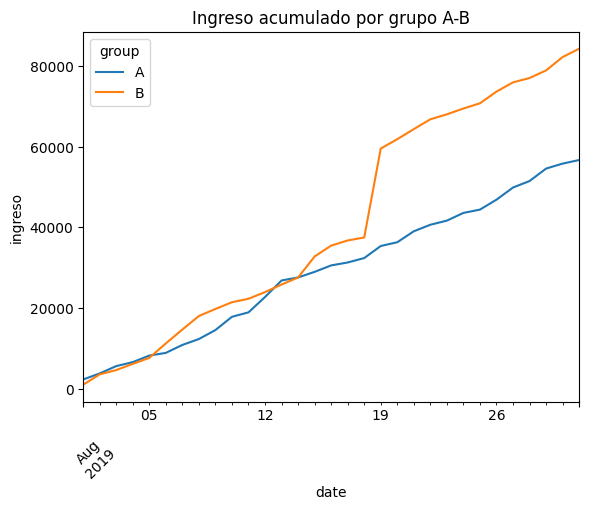

In [148]:
#Identificar las fechas y grupos unicos de la tabla order
date_group=order_[['date','group']].drop_duplicates().sort_values(by='date')
# 
order_agregado=date_group.apply(lambda x: order_[np.logical_and(order_['date'] <= x['date'], order_['group']==x['group'])].
                                agg({'date':'max',
                                     'group':'max',
                                     'transactionId':pd.Series.nunique,
                                     'visitorId':pd.Series.nunique,
                                     'revenue':'sum'}),axis=1).sort_values(by=['date','group'])
#Identificar las fechas y grupos unicos de la tabla visitas
visitas_agregado=visitorsAggregated = (
    date_group.apply(lambda x: visitas[np.logical_and(visitas['date'] <= x['date'], visitas['group'] == x['group'])]
                      .agg({'date' : 'max', 
                            'group' : 'max', 
                            'visits' : 'sum'}), 
                      axis=1
                     )
    .sort_values(by=['date','group'])
    
)
#fusionar las 2 tablas de order_agregado y visitor_agregado
data_acumulativa=order_agregado.merge(visitas_agregado, left_on=['date','group'], right_on=['date','group'])
data_acumulativa.columns=['date','group','n_orders','buyers','revenue','visitors']
# Tomar en cuenta el ingreso acumulado y comparar por grupo mediante una diagrama de línea
data_acumulativa.pivot_table(
    index='date',
    columns='group',
    values='revenue',
    aggfunc='mean'
).plot(kind='line', title='Ingreso acumulado por grupo A-B', xlabel='date', ylabel='ingreso')
plt.gca().tick_params(axis='x', rotation=45)
plt.show()



los ingresos acumulativo del grupo B hay un pico en el día 19 de agosto. Esto podía implicar un aumento en el número de pedidos o existencia de pedido muy caros en la muestra. 

### Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

In [149]:
data_acumulativa

,date,group,n_orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,43,37,3770.1,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,67,61,5585.3,1845
...,...,...,...,...,...,...
57,2019-08-29,B,538,509,78939.9,17708
58,2019-08-30,A,490,459,55821.9,18037
59,2019-08-30,B,560,530,82262.5,18198
60,2019-08-31,A,499,468,56716.1,18736


<AxesSubplot:title={'center':'Tmaño acumulado por grupo A-B'}, xlabel='date', ylabel='ingreso'>

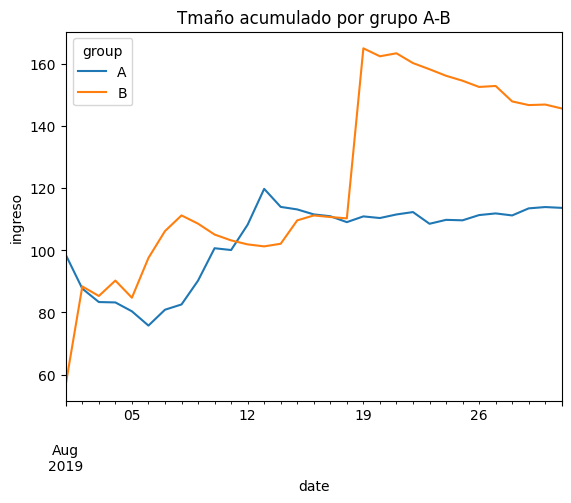

In [150]:
#agregar una columna de promedio acumulativo
data_acumulativa['tamaño_mean_acumulative']=data_acumulativa['revenue']/data_acumulativa['n_orders']
# crear frafica de ambos grupos
data_acumulativa.pivot_table(index='date',
                          columns='group',
                          values='tamaño_mean_acumulative',
                          aggfunc='mean').plot(kind='line',title='Tmaño acumulado por grupo A-B', xlabel='date', ylabel='ingreso')


Ambos grupo han estado constante crecimiento en su promedio de compra hasta el dia 18.Apartir del dia 19 hay una diferencia de tamaño de promedio para el grupo B.

**Causa de la diferencia en grupo B en el dia 19**
 - Pedidos costoso
 - Menor cantidad de pedidos

Pero aunque al final de la fecha no podemos suponer que se pueda estabilizar ambos grupo.Podemos notar que hay una caida del promedio del grupo B por el cual los ingreso de los pedidos estan cayendo o se esta realizando mayoy cantidad de pedidos.

### Representar gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. 

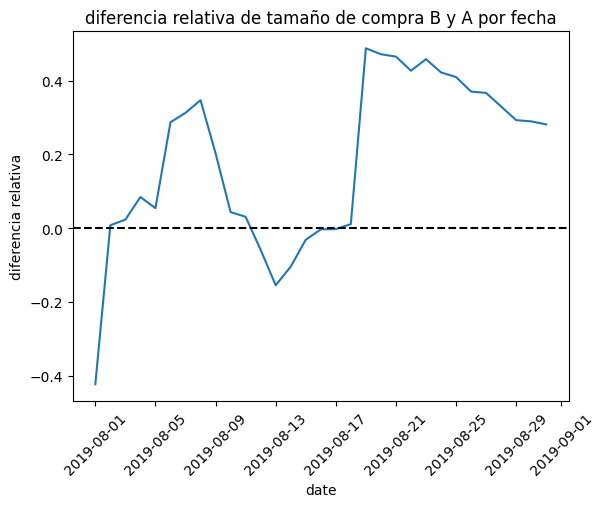

In [151]:
#Dataframe con tamaño promedio acumulado por dia , grupo A 
acumulative_revenue_A=data_acumulativa.query("group=='A'")[['date','tamaño_mean_acumulative']]
#Dataframe con tamaño promedio acumulado por dia , grupo A 
acumulative_revenue_B=data_acumulativa.query("group=='B'")[['date','tamaño_mean_acumulative']]
#Reunir los datos en un dataframe de ambos grupos A y B
mergeacumulativeRevenue=acumulative_revenue_A.merge(acumulative_revenue_B, left_on='date',right_on='date',how='left', suffixes=['A','B'])
#Crear la frecuencia en dataFrame 
mergeacumulativeRevenue['relativa_a_b']=(mergeacumulativeRevenue['tamaño_mean_acumulativeB']/mergeacumulativeRevenue['tamaño_mean_acumulativeA'])-1
# Trazar el grafico
plt.plot(mergeacumulativeRevenue['date'],mergeacumulativeRevenue['relativa_a_b'])
plt.xlabel('date')
plt.ylabel('diferencia relativa')
plt.title('diferencia relativa de tamaño de compra B y A por fecha')
plt.axhline(y=0, color='black',linestyle='--')
plt.gca().tick_params(axis='x', rotation=45)

La diferencia entre los segmento aumenta en algunos dias siendo los picos mas alto en el dia 19 , pero a partir de esa fecha disminuyó.
* los valores picos que aparecen podemos entender que posiblemente hay valores atipicos en los datos de los ingresos de pedido

### Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.

Text(0, 0.5, 'conversion')

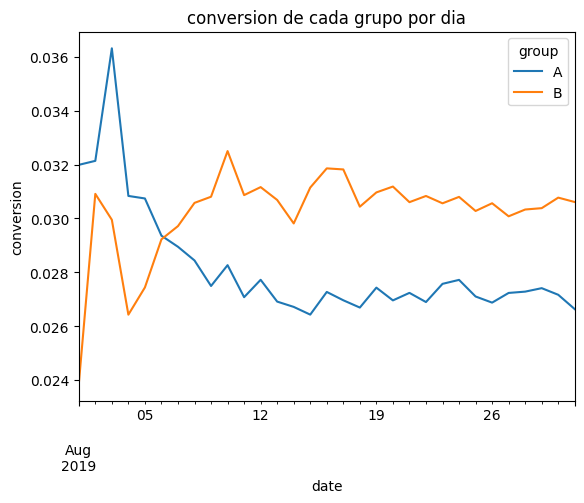

In [152]:
data_acumulativa['conversion']=data_acumulativa['n_orders']/data_acumulativa['visitors']
data_acumulativa.pivot_table(index='date',
                          columns='group',
                          values='conversion',
                          aggfunc='mean').plot(kind='line')
plt.title('conversion de cada grupo por dia')
plt.xlabel('date')
plt.ylabel('conversion')

**Grupo A:** Fue disminuyendo a la conversion acumulada desde el 3 de agosto.
             Hay una conversion acumulado alrededor del 3%.

**Grupo B:** 
Aumento relativamente la conversion acumulada a partir del 4 de agosto.A partir del 7 de octubre han tenido una conversión acumulado mayor que  3.3 %.  

Hay una pequeña diferencia en ambos grupos. Podemos resaltar que el grupo B hay una mayor conversion en casi todas la fechas. Es decir que hubo mayor interes en comprar en los usuarios del grupo B.

### Traza un gráfico de dispersión del número de pedidos por usuario

Text(0, 0.5, 'Número de pedidos')

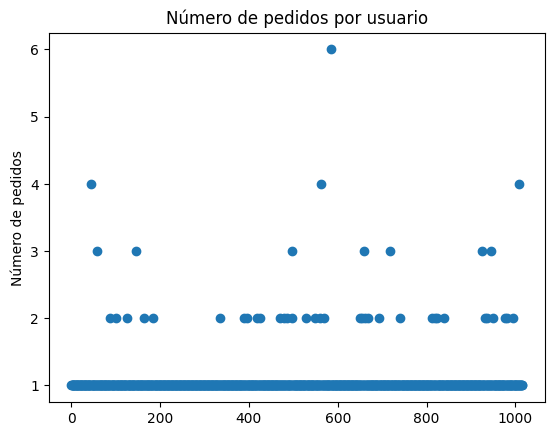

In [153]:
#De la tabla Order agrupar por usuario y sumar los cantidad de pedidos
orderbyUsuario=order_.drop(['date','revenue','group'], axis=1).groupby('visitorId',as_index=False)['transactionId'].nunique()
#Trazar grafico
plt.scatter(orderbyUsuario.index ,orderbyUsuario['transactionId'])
plt.title('Número de pedidos por usuario')
plt.ylabel('Número de pedidos')

* Hay muchos usuario que realizaron mas 6 o 8 pedidos durante el mes de agosto.

### Calculo de  los percentiles 95 y 99 del número de pedidos por usuario. Definir el punto en el cual un punto de datos se convierte en una anomalía.

In [154]:
percentile_95=np.percentile(orderbyUsuario['transactionId'],[95,99])[0]
percentile_99=np.percentile(orderbyUsuario['transactionId'],[95,99])[1]
print(f'El percentil 95 del número de pedidos por usuaros es {percentile_95}')
print(f'El percentil 99 del número de pedidos por usuaros es {percentile_99}')

El percentil 95 del número de pedidos por usuaros es 1.0
El percentil 99 del número de pedidos por usuaros es 2.8500000000000227


No mas de 1% de los usuarios realizaron mas de 3 pedidos y el 5% de los usuarios realizaron un pedido.Seria razonable fijar un umbral de 2 pedidos por usuario como limite superior para un comportamiento normal  y utilizarlo para filtrar cualquier anomalía.

### Trazar un gráfico de dispersión de los precios de los pedidos.

Text(0, 0.5, 'precios')

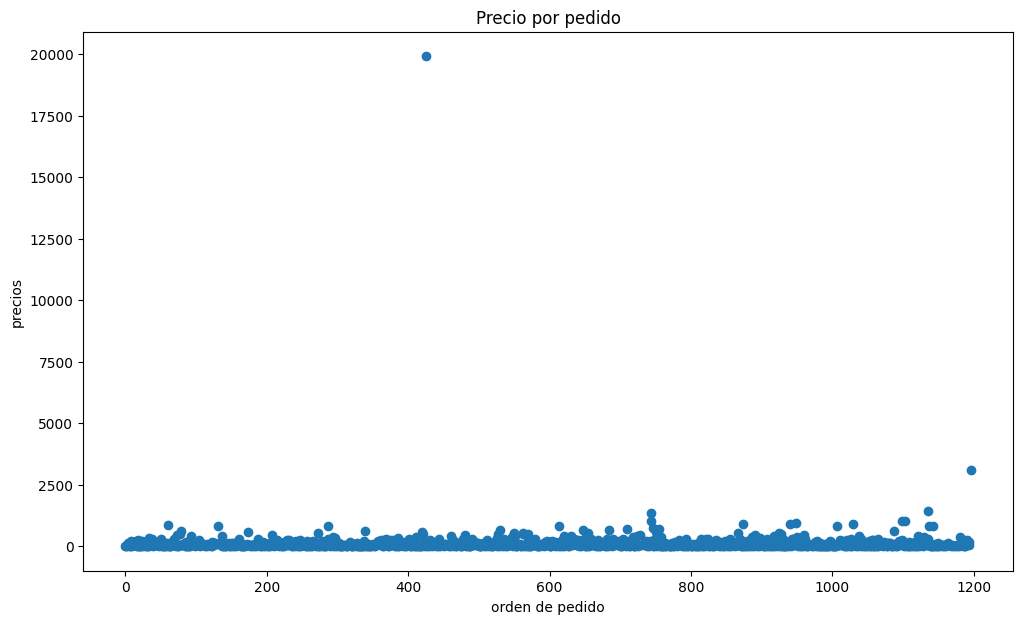

In [155]:
#utilizar la tabla order y filtra el precio de lso pedidos
plt.figure(figsize=(12,7))
plt.scatter(order_.index ,order_['revenue'])
plt.title('Precio por pedido')
plt.xlabel('orden de pedido')
plt.ylabel('precios')

* Hay un 1 pedido que cuesta 20000 por el cual se le podia considera como valor atípico.
* Los demas datos son mucho mas pequeños menos 2500 

### Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [156]:
percentile_95=np.percentile(order['revenue'],[95,99])[0]
percentile_99=np.percentile(order['revenue'],[95,99])[1]
print(f'El percentil 95 de los precios de los pedidos es {percentile_95}')
print(f'El percentil 99 de los precios de los pedidos es {percentile_99}')

El percentil 95 de los precios de los pedidos es 435.54
El percentil 99 de los precios de los pedidos es 900.9039999999999


* No mas del 5% de los pedidos cuestan 435.54 y no mas del 1% cuestan mas de 900

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [157]:
# Agrupar de la tabla Order por grupo y usuario y sumar su numero de pedido
order_usuario=order_.groupby(['group','visitorId'])['transactionId'].nunique().reset_index()
order_usuario=order_usuario.rename(columns={'transactionId':'orders'})
# Filtrar del DataFrame los pedidos de cada usuarios del grupo A
order_usuario_A=order_usuario.query("group=='A'")
# Filtrar del DataFrame los pedidos de cada usuarios del grupo A
order_usuario_B=order_usuario.query("group=='B'")
print(order_usuario_B)
print(order_usuario_A)

     group   visitorId  orders
468      B     5114589       1
469      B     6958315       1
470      B    39475350       1
471      B    47206413       1
472      B    48147722       1
...    ...         ...     ...
1011     B  4256040402       4
1012     B  4258103007       1
1013     B  4279090005       1
1014     B  4281247801       1
1015     B  4283872382       1

[548 rows x 3 columns]
    group   visitorId  orders
0       A     8300375       1
1       A    11685486       1
2       A    54447517       1
3       A    66685450       1
4       A    78758296       1
..    ...         ...     ...
463     A  4227830084       1
464     A  4237561104       1
465     A  4243832526       1
466     A  4259830713       1
467     A  4278982564       1

[468 rows x 3 columns]


In [158]:
# Crear una serie de O a las Visitas del grupo A que no hicieron ningun pedido
pd.Series(0,index=np.arange(visitas[visitas['group']=='A']['visits'].sum()-len(order_usuario_A['orders'])))

# Crear una serie de O a las Visitas del grupo A que no hicieron ningun pedido
pd.Series(0,index=np.arange(visitas[visitas['group']=='B']['visits'].sum()-len(order_usuario_B['orders'])))

#Pasar cada argumento a una lista de pedidos por usuario y por cada grupo 
lista_orders_A=pd.concat([order_usuario_A['orders'],pd.Series(0,index=np.arange(visitas[visitas['group']=='A']['visits'].sum()-len(order_usuario_A['orders'])),name='orders')],axis=0)
lista_orders_B=pd.concat([order_usuario_A['orders'],pd.Series(0,index=np.arange(visitas[visitas['group']=='B']['visits'].sum()-len(order_usuario_B['orders'])),name='orders')],axis=0)

# Probar estadisticamente si hay una diferencia entre la cantidad de pedidos por usuario de cada grupo
print("{0:.3f}".format(stats.mannwhitneyu(lista_orders_A,lista_orders_B)[1]))

print("{0:.3f}".format(lista_orders_B.mean()/lista_orders_A.mean()-1))

0.934
-0.005


El valor pvalue es  mayor que 0.05. Entonces no podemos rechazar la hipotesis nula, ya que no hay diferencia estadistica significativa en la coversión.Pero hay una perdida relativa del grupo B de 0.5%, no es mucha la diferencia. 

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [159]:
print('{0:.3f}'.format(stats.mannwhitneyu(order_[order_['group']=='A']['revenue'],order_[order_['group']=='B']['revenue'])[1]))
print('{0:.12f}'.format(order_[order_['group']=='B']['revenue'].mean()/order_[order_['group']=='A']['revenue'].mean()-1))

0.989
0.281304645735


No se puede rechazar la hipotesis nula : No hay una diferencia estadistica significativa en el tamaño del promedio de pedido en ambos grupo.Hay una ganancia relativa del 28% del grupo B sobre su tamaño de promedio.

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

 Se va a definir los usuarios anómalos 
- Los que realizaron mas de 4 pedidos
- los que compraron pedidos mas de 900 $

In [160]:
#Definir los usuarios con mayor de 4 pedidos y mas de 900 por pedido
usuario_ManyOrders=order_usuario[order_usuario['orders']>4]['visitorId']
usuario_expensiveRevenue=order_[order_['revenue']>900]['visitorId']
anomalias_usuarios = pd.concat([usuario_ManyOrders,usuario_expensiveRevenue], axis=0).drop_duplicates().sort_values()
print(anomalias_usuarios)
print(anomalias_usuarios.shape)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
425     1920142716
1196    2108080724
1029    2378935119
793     2458001652
940     4003628586
743     4133034833
873     4256040402
Name: visitorId, dtype: int64
(12,)


* Son 12 usuarios que cumple estas anomalias

In [161]:
#filtrar y tomar en consideracion los usuarios que presenta anomalia en el grupo A
lista_orders_A_filtrada=pd.concat([order_usuario_A[~order_usuario_A['visitorId'].isin(anomalias_usuarios)]['orders'],pd.Series(0,index=np.arange(visitas[visitas['group']=='A']['visits'].sum()-len(order_usuario_A['orders'])),name='orders')],axis=0)
#filtrar y tomar en consideracion los usuarios que presenta anomalia en el grupo B
lista_orders_B_filtrada=pd.concat([order_usuario_B[~order_usuario_B['visitorId'].isin(anomalias_usuarios)]['orders'],pd.Series(0,index=np.arange(visitas[visitas['group']=='B']['visits'].sum()-len(order_usuario_B['orders'])),name='orders')],axis=0)

#Aplicar el metodo estadistico de Mann-Whitney a las muestras
print("{0:.3f}".format(stats.mannwhitneyu(lista_orders_A_filtrada,lista_orders_B_filtrada)[1]))
print("{0:.3f}".format(lista_orders_B_filtrada.mean()/lista_orders_A_filtrada.mean()-1))

0.016
0.142


* Se rechaza la hipótesis nula: Ambos grupos son diferentes , hay una significancia estadística.
* La conversion del grupo B tiene una ganancia relativa del 14%  mayor que el grupo A

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [162]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    order_[np.logical_and(order_['group']=='A', np.logical_not(order_['visitorId']
                                                             .isin(anomalias_usuarios)))]['revenue'],
    order_[np.logical_and(order_['group']=='B', np.logical_not(order_['visitorId']
                                                             .isin(anomalias_usuarios)))]['revenue'])[1]))
#Mostrar la diferencia relativa en el ingreso medio entre los grupos B y A
print(order_[np.logical_and(order_['group']=='B', np.logical_not(order_['visitorId']
                                                             .isin(anomalias_usuarios)))]['revenue'].mean()
     /order_[np.logical_and(order_['group']=='A', np.logical_not(order_['visitorId']
                                                             .isin(anomalias_usuarios)))]['revenue'].mean() -1
     )

0.935
-0.02385091857954702


* No podemos rechazar la hipotesis Nula: No podemos decir que haya una diferencia de significancia estadistica.
* Con respecto a la tamaño relativo del grupo B hay perdida de 2.3 % muy pequeño a comparcion al grupo A

### Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Parar la prueba, considerar a uno de los grupos como líder. 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 3. Continuar la prueba.

* Los datos filtrados muestra una diferencia estadistica significativa en la conversión entre los grupos, y podemos entender que ese grupo que tiene una mayor conversion es del grupo B con 14%, es decir hubo mayor usuario que hicieron pedidos.
* Ni los datos sin procesar ni los filtrados muestra una diferencia estadística significativa en el tamaño promedio de los pedidos en ambos grupos.

* La prueba no fue tan exitosa ya que no hay una diferencia significativa entre ambos grupo. Despues de filtrar los datos  del grupo B hubo una **mayor** conversion es decir hubo mayor usuario que visitaron y lograron comprar pero sus pedidos no fueron costoso.
* Con respecto a la tamaño promedio relativo entre los grupos nos dice que el promedio de tamño del grupo B va cayendo dia a dia no hay un tendencia de subida.
* Podemos concluir hasta el dia de hoy hay ligera diferencia en conversion mas en el grupo B pero en tamaño no hay mucha diferencia.Hasta el dia de hoy va disminuyendo en tamaño con un  

**Podemos concluir la prueba.**